___
This notebook tries to address two questions for rental lease:
1. is there a seasonality effect for certain months and areas?
1. how long should the lease be? 12, or 24?

In [928]:
%matplotlib inline
import pandas as pd
import numpy as np
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import Select
from selenium.webdriver.common.action_chains import ActionChains
import time
import glob
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from sklearn import datasets, linear_model
from sklearn.cross_validation import KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
import sklearn.preprocessing as pp
from fbprophet import Prophet
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
from datetime import timedelta,datetime
import warnings
warnings.filterwarnings("ignore")

## Scope of analysis
- Data pull
- Pre-process data
- Forecast rental amount of each month for each district*
- Find out which district in each month is cheapest (and most expensive)
- Find out the amount of savings for each district
- Predict rental prices for each district for the next 24 months
- Find out the amount of savings for each district from prediction of next 24 months
- Get total savings
- Plot out districts that are top 10 in savings to see predict fit

*1 BR is only looked into here, although data for 2BR and 3BR are pulled too

## Summary
- Total savings of lease can be up to `$`7,854 (avg total savings: `$`2538.05)
    - Savings from extending lease to 24 months, can be up to `$`2070 (avg total savings: `$`644)
    - Savings from leasing on the lowest month, can be up to `$`7854 (avg total savings: `$`2254)
- The districts that have the most savings are `7, 1, 21 ,2, 3`

## Data pull
- due to the nature of the website and how the data can be pulled from the website
- a web scrap 'script' needs to be in placed so that we will not have to manually go through the steps and obtain the data
- Selenium is used to pull all the data required

### Initialize selenium browser

In [156]:
driver = webdriver.Chrome()
driver.get("https://www.ura.gov.sg/realEstateIIWeb/resiRental/changeDisplayUnit.action")

### Loop through all condos to obtain data

In [161]:
# for i in range(0,600):
#     print(i)
#     from_date_element = driver.find_element_by_name("from_Date_Prj")
#     to_date_element = driver.find_element_by_name("to_Date_Prj")
#     Select(from_date_element).select_by_value("JAN-2016")
#     Select(to_date_element).select_by_value("DEC-2018")
#     for j in range(0,5):
#         text = "addToProject_" + str(i*5+j)
#         project_element = driver.find_element_by_id(text)
#         project_element.click()
#         time.sleep(0.5)
#     driver.find_element_by_xpath('//*[@id="searchForm_0"]').click()
#     driver.find_element_by_xpath('//*[@id="SubmitSortForm"]/div[1]/div[3]').click()
#     time.sleep(1)
#     driver.find_element_by_xpath('//*[@id="SubmitSortForm"]/div[1]/div[4]').click()
#     print("finish")

driver.stop_client()

### Read csv files, and aggregate them

In [3]:
file = "../data/aggregate_raw_data.csv"
if not os.path.exists(file):
    aggregate_df = None
    for files in glob.glob("../data/*.csv"):
        processed_raw_df = (
            pd.read_csv(files)
            .dropna()
            .reset_index()
        )
        processed_raw_df.columns = processed_raw_df.iloc[0]
        processed_raw_df = processed_raw_df.reindex(processed_raw_df.index.drop(0))

        if aggregate_df is None:
            aggregate_df = processed_raw_df
        else:
            aggregate_df = (
                aggregate_df
                .append(processed_raw_df)
            )
    aggregate_df.to_csv('../data/aggregate_raw_data.csv',index=False)
else:
    aggregate_df = pd.read_csv("../data/aggregate_raw_data.csv")

## Pre process data
- minor pre-process data
- pre-process data
- decision if mean or median of monthly rental should be used for predicted variable

### Minor pre-process data
- change column names and data type of columns

In [1014]:
# change column names and drop first column and change data type of columns
aggregate_df_processed = (
    aggregate_df
    .drop(['S/N'],1)
    .rename(columns={"Building/Project Name":"building_name","Street Name":"street_name","Postal District":"district",
                     "No. of Bedroom(for Non-Landed Only)":"num_bedrooms","Monthly Gross Rent($)":"monthly_rent",
                     "Floor Area (sq ft)":"sq_ft","Lease Commencement Date":"lease_month","Type":"type"})
    .pipe(lambda x:x.assign(lease_month = pd.to_datetime(x.lease_month)))
    .pipe(lambda x:x.assign(monthly_rent = x.monthly_rent.astype(float)))
    .query("(type == 'Non-landed Properties' | type == 'Executive Condominium')")
)

### Pre-process data
- fill in missing data of number of bedrooms
- set the size of the property
- one hot encode which month the rental lease is signed
- introduce trend variables (up to third order)

In [5]:
aggregate_df_processed_final = (
    aggregate_df_processed
    .query("(type == 'Non-landed Properties' | type == 'Executive Condominium')")
    .pipe(lambda x:x.assign(sq_ft = np.where(
                                            x.sq_ft == '>3000',"3100 to 3100",
                                            np.where(x.sq_ft == '>8000',"8100 to 8100",x.sq_ft)
    )))
    .pipe(lambda x:x.assign(sq_ft_altered = x.sq_ft.str.split(' to ').str[1].astype(float)))
    .pipe(lambda x:x.assign(num_bedrooms_altered = np.where(
        x.sq_ft_altered <= 646.085859, 1, np.where(x.sq_ft_altered <= 1037.376865, 2,
                                                  np.where(x.sq_ft_altered <= 1521,3,
                                                          np.where(x.sq_ft_altered <= 2346,4,
                                                                  np.where(x.sq_ft_altered <= 3034,5,
                                                                          np.where(x.sq_ft_altered <= 3100,6,7)))))
    )))
    .pipe(lambda x:x.assign(monthly_rent = x.monthly_rent.astype(float)))
)

In [389]:
model_data = (
    aggregate_df_processed_final
    .pipe(lambda x:x.assign(m1 = np.where(pd.to_datetime(x.lease_month).dt.month == 1,1,0)))
    .pipe(lambda x:x.assign(m2 = np.where(pd.to_datetime(x.lease_month).dt.month == 2,1,0)))
    .pipe(lambda x:x.assign(m3 = np.where(pd.to_datetime(x.lease_month).dt.month == 3,1,0)))
    .pipe(lambda x:x.assign(m4 = np.where(pd.to_datetime(x.lease_month).dt.month == 4,1,0)))
    .pipe(lambda x:x.assign(m5 = np.where(pd.to_datetime(x.lease_month).dt.month == 5,1,0)))
    .pipe(lambda x:x.assign(m6 = np.where(pd.to_datetime(x.lease_month).dt.month == 6,1,0)))
    .pipe(lambda x:x.assign(m7 = np.where(pd.to_datetime(x.lease_month).dt.month == 7,1,0)))
    .pipe(lambda x:x.assign(m8 = np.where(pd.to_datetime(x.lease_month).dt.month == 8,1,0)))
    .pipe(lambda x:x.assign(m9 = np.where(pd.to_datetime(x.lease_month).dt.month == 9,1,0)))
    .pipe(lambda x:x.assign(m10 = np.where(pd.to_datetime(x.lease_month).dt.month == 10,1,0)))
    .pipe(lambda x:x.assign(m11 = np.where(pd.to_datetime(x.lease_month).dt.month == 11,1,0)))
    .pipe(lambda x:x.assign(m12 = np.where(pd.to_datetime(x.lease_month).dt.month == 12,1,0)))
    .pipe(lambda x:x.assign(min_year = pd.to_datetime(x.lease_month).dt.year.min()))
    .pipe(lambda x:x.assign(time = 12*(pd.to_datetime(x.lease_month).dt.year-x.min_year) + pd.to_datetime(x.lease_month).dt.month))
    .pipe(lambda x:x.assign(time_time = x.time * x.time))
    .pipe(lambda x:x.assign(time_time_time = x.time * x.time * x.time))
)

### Decision if mean or median of monthly rental should be used for predicted variable
- predicted variable = dependent variable = variable we are trying to predict = monthly rent
- limiting to 3 bedrooms or lesser

In [1078]:
decision_mean_median = (
    model_data
    .pipe(lambda x:x.assign(monthly_rent_copy = x.monthly_rent))
    [['lease_month','district','num_bedrooms_altered','monthly_rent','monthly_rent_copy']]
    .groupby(['lease_month','district','num_bedrooms_altered'])
    .agg({"monthly_rent":"mean","monthly_rent_copy":"median"})
    .reset_index()
    .pipe(lambda x:x.assign(difference_between_mean_median = x.monthly_rent_copy - x.monthly_rent))
    .query("num_bedrooms_altered <= 3")
)

decision_mean_median.head()

,lease_month,district,num_bedrooms_altered,monthly_rent,monthly_rent_copy,difference_between_mean_median
0,2016-01-01,1,1,2975.000000,3250.0,275.000000
1,2016-01-01,1,2,4463.888889,4500.0,36.111111
2,2016-01-01,1,3,5838.000000,5950.0,112.000000
5,2016-01-01,2,1,3277.500000,3325.0,47.500000
6,2016-01-01,2,2,4193.000000,4200.0,7.000000


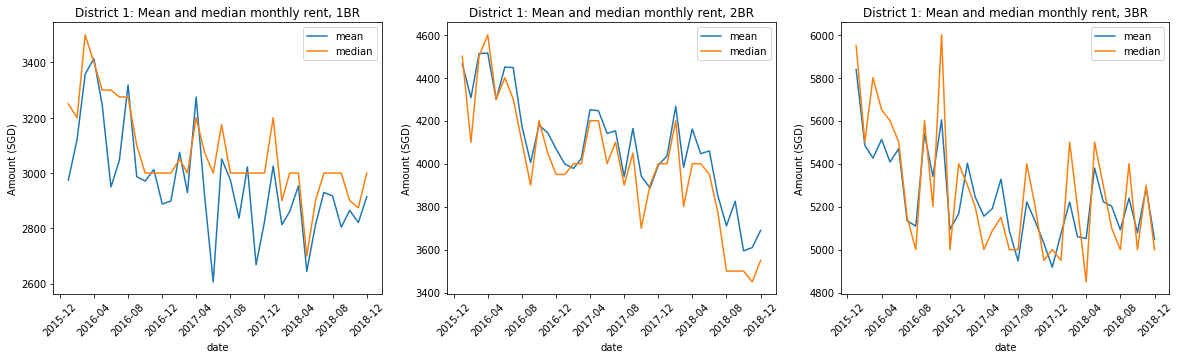

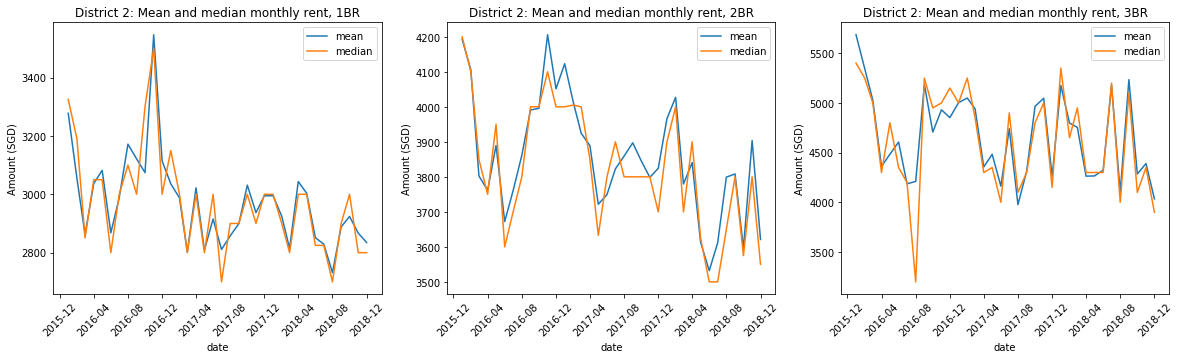

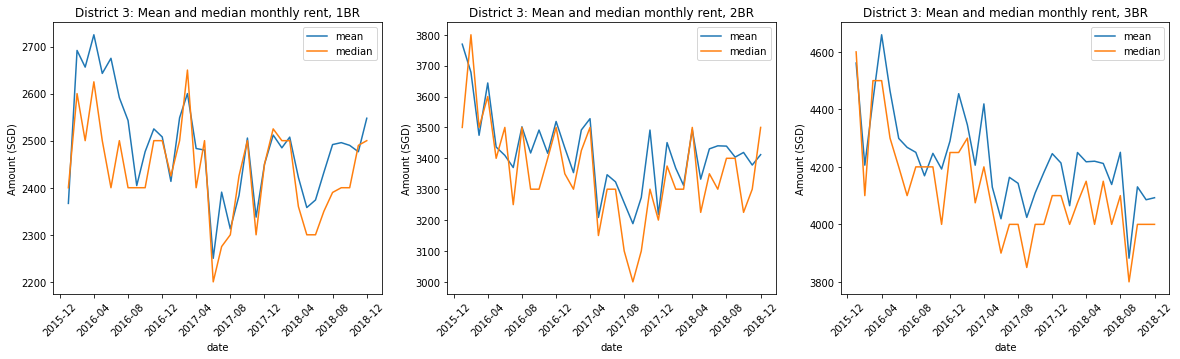

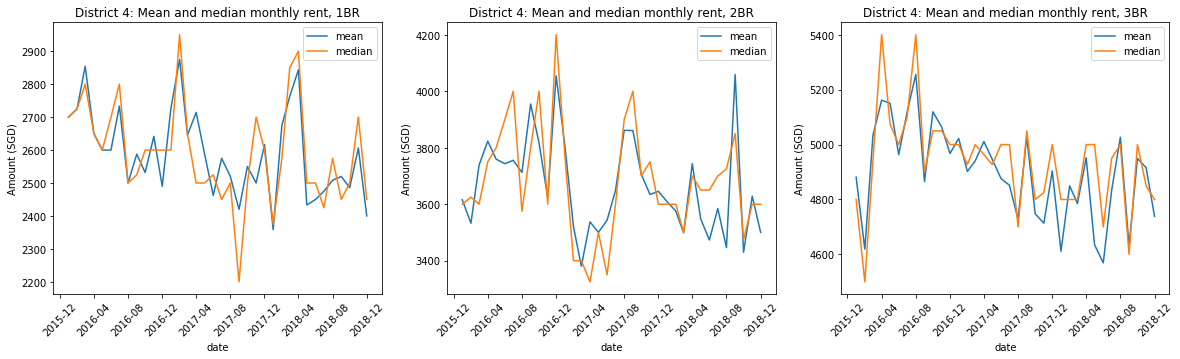

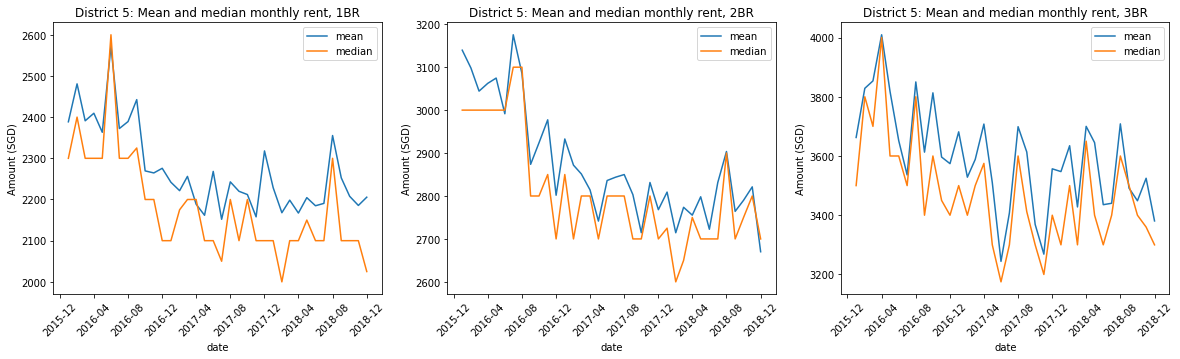

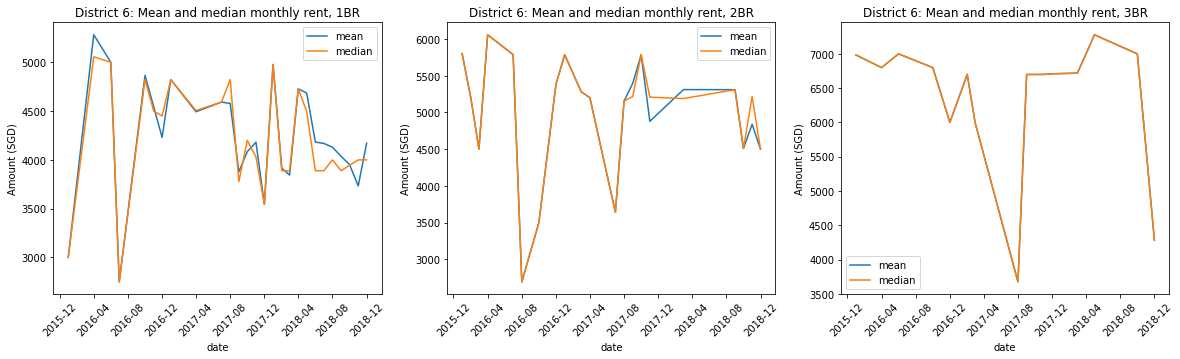

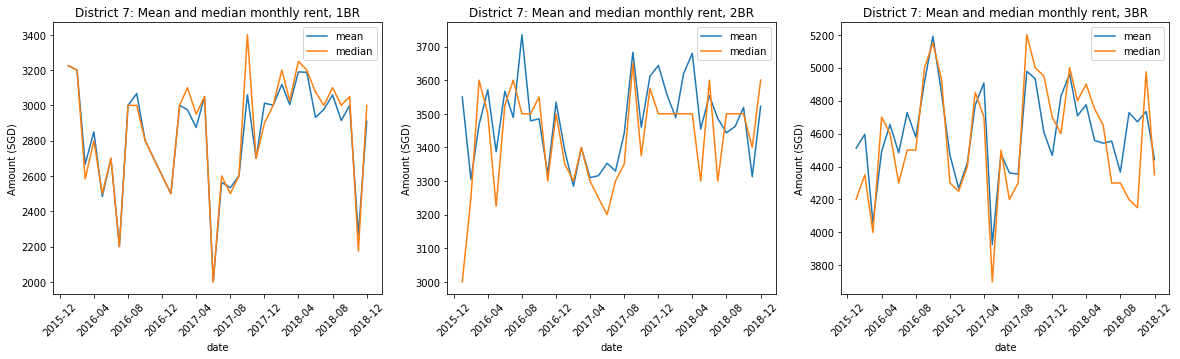

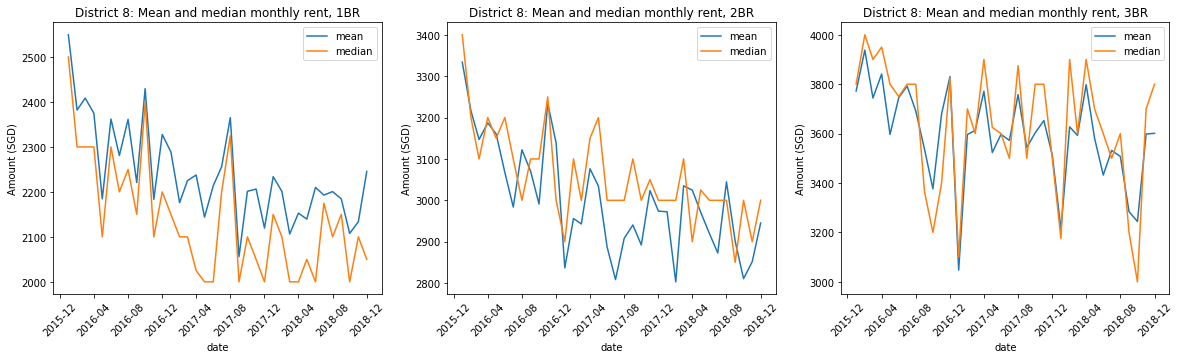

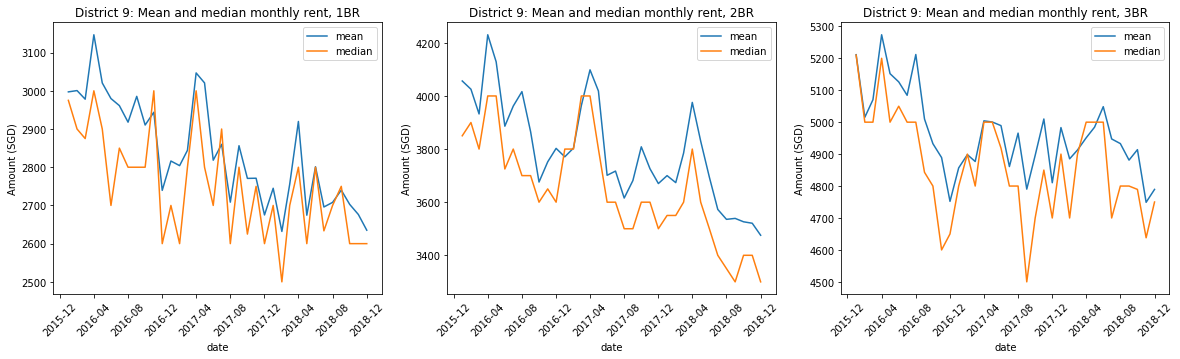

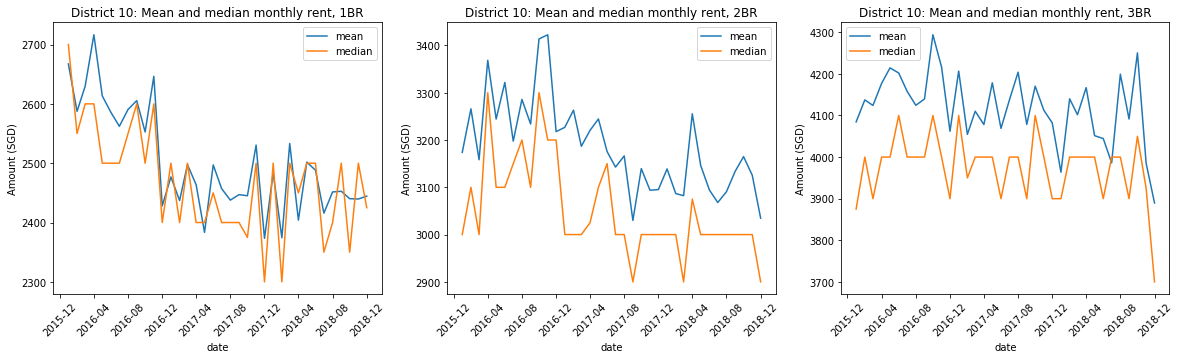

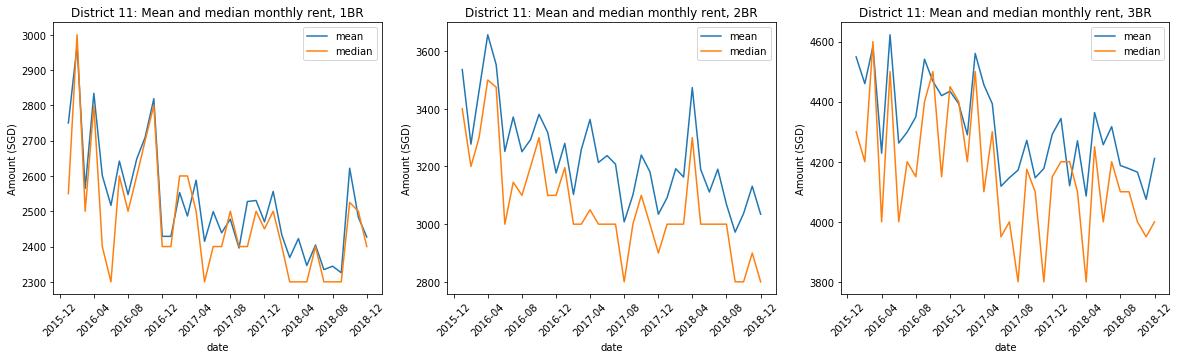

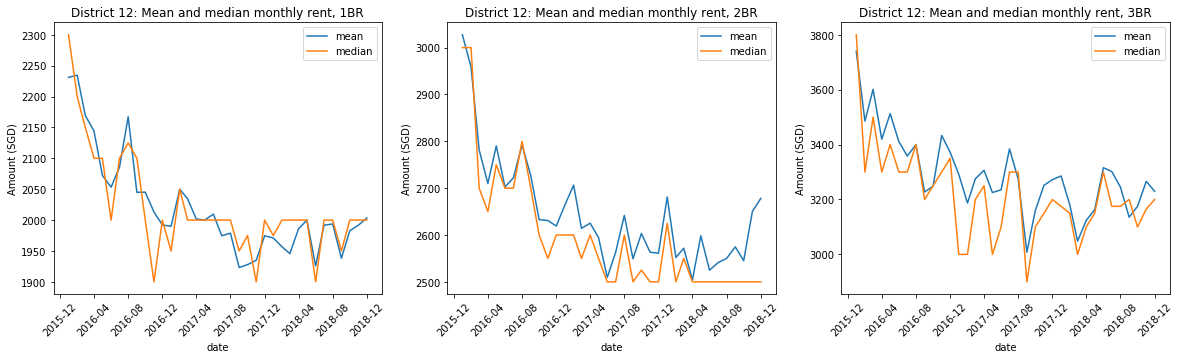

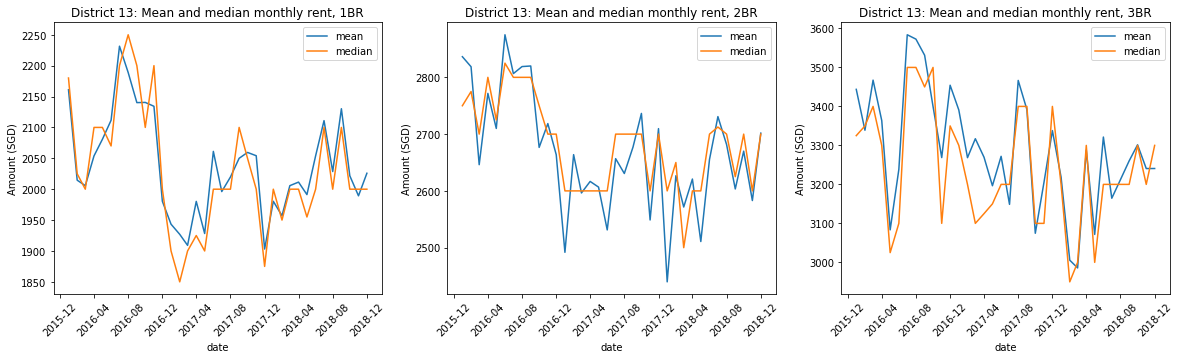

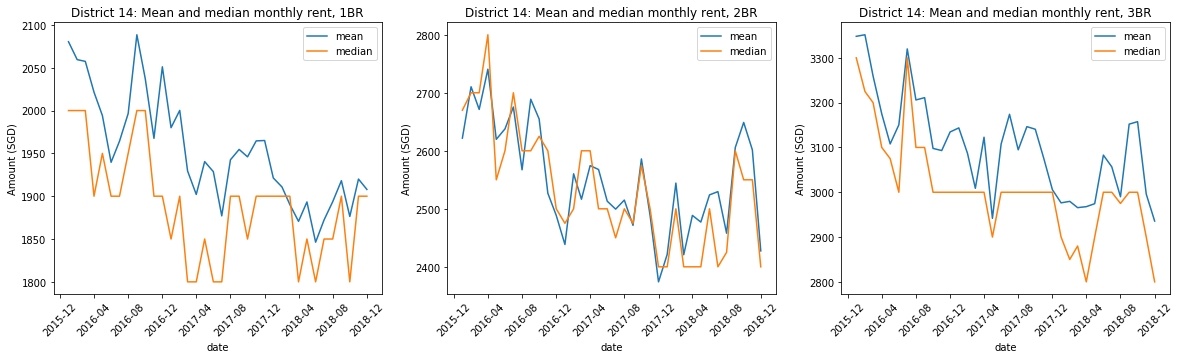

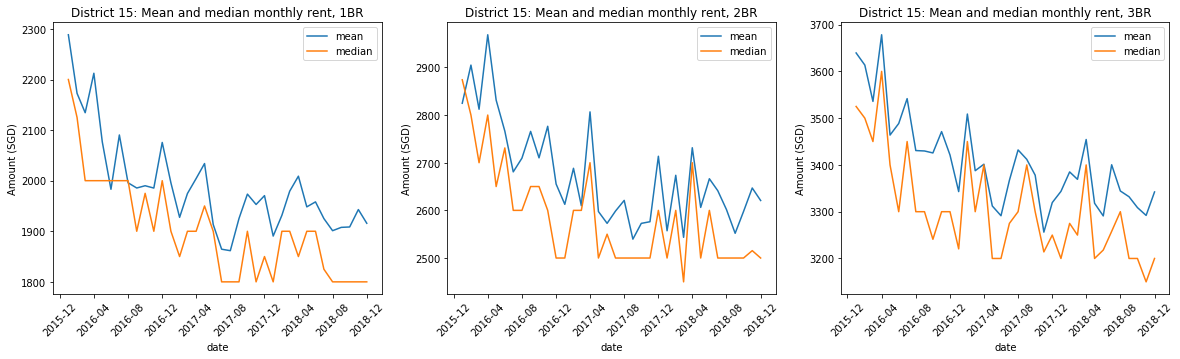

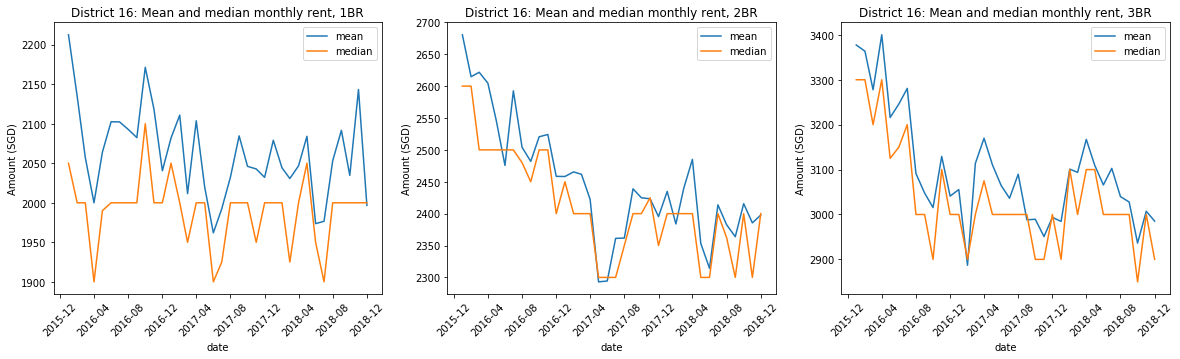

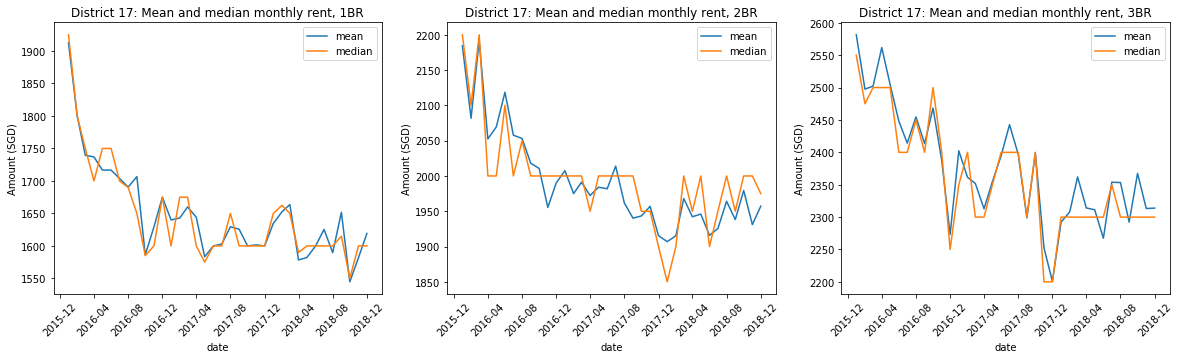

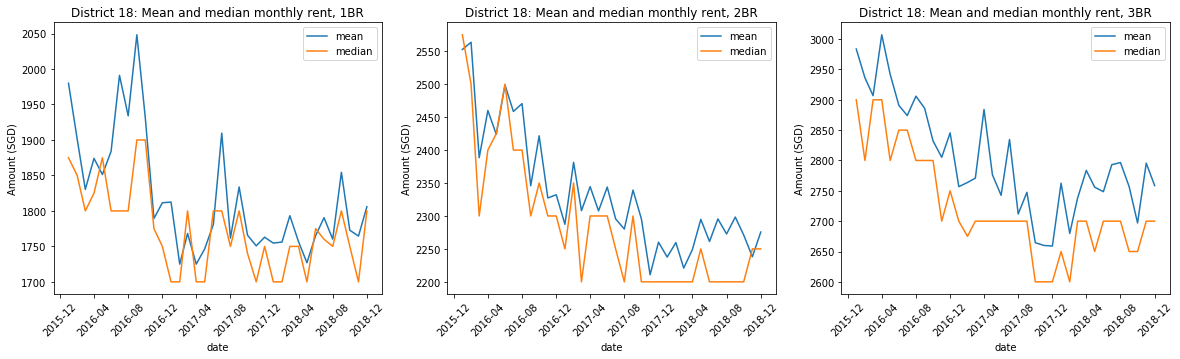

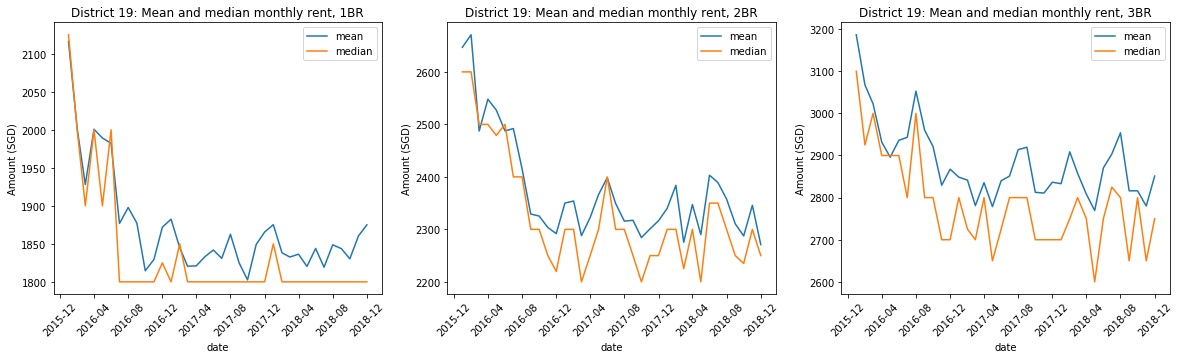

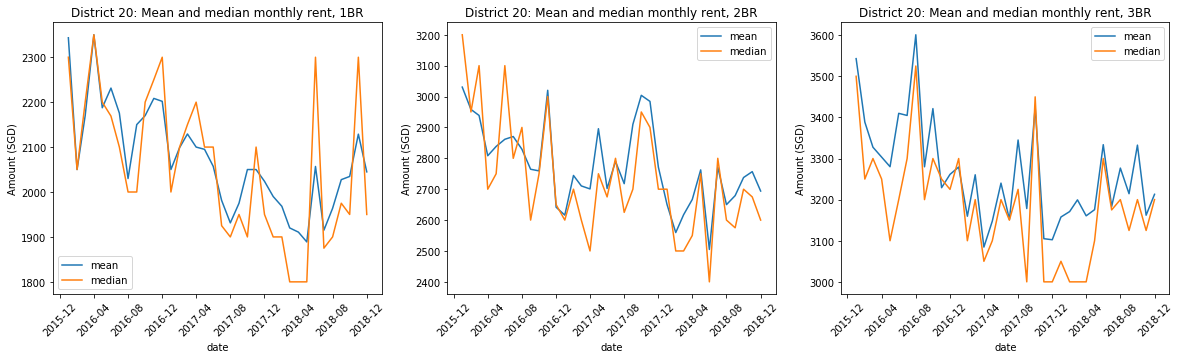

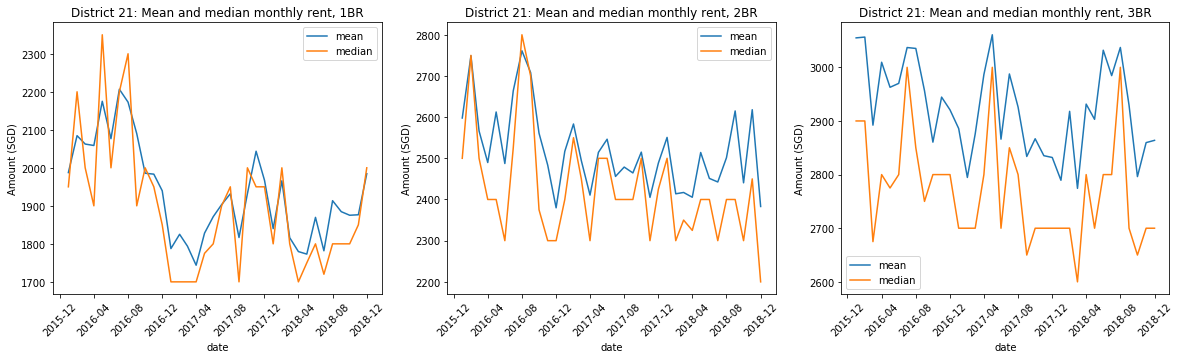

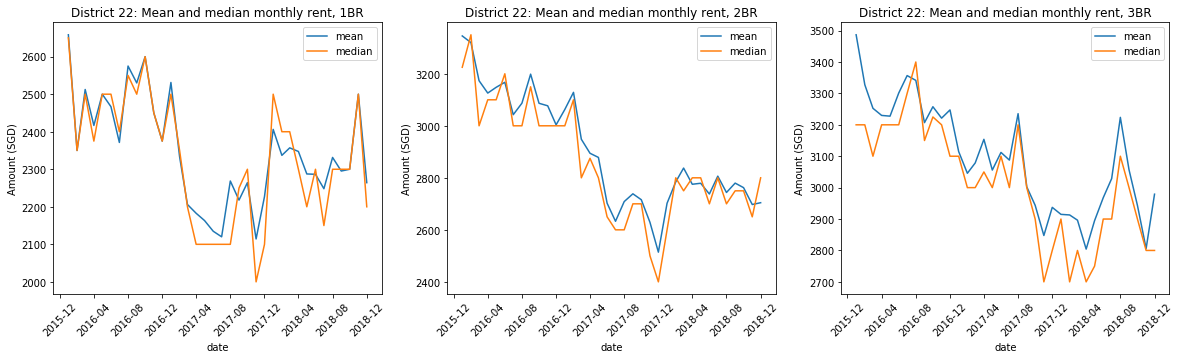

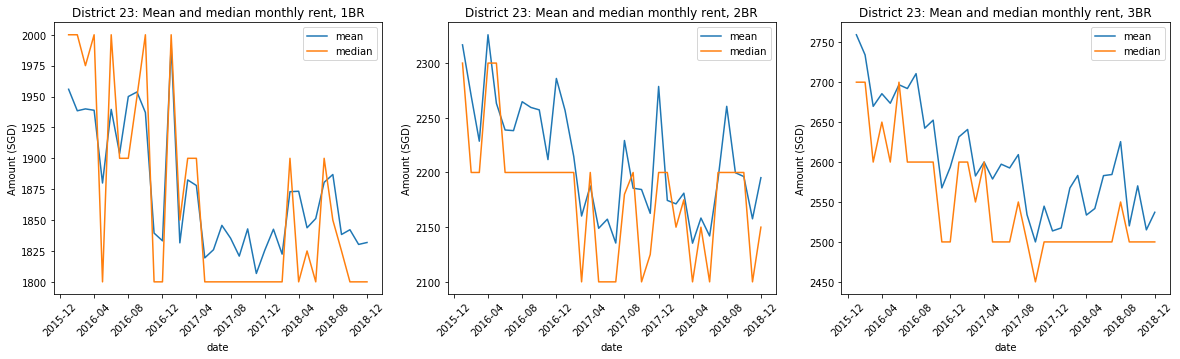

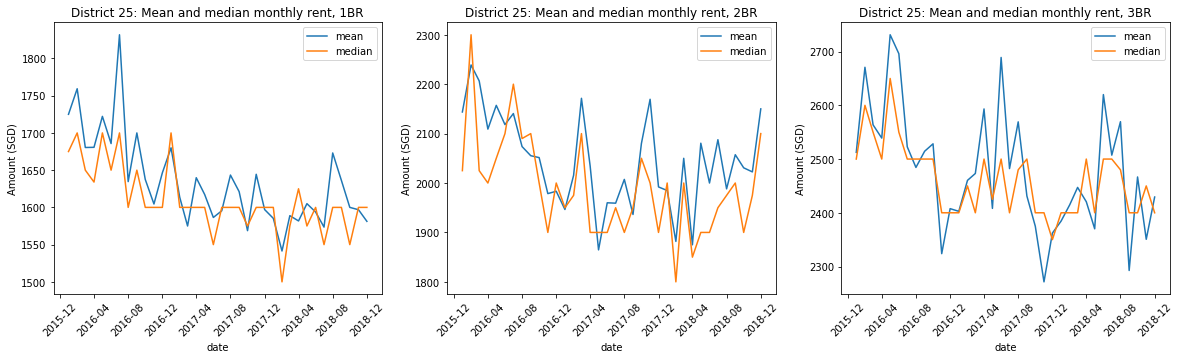

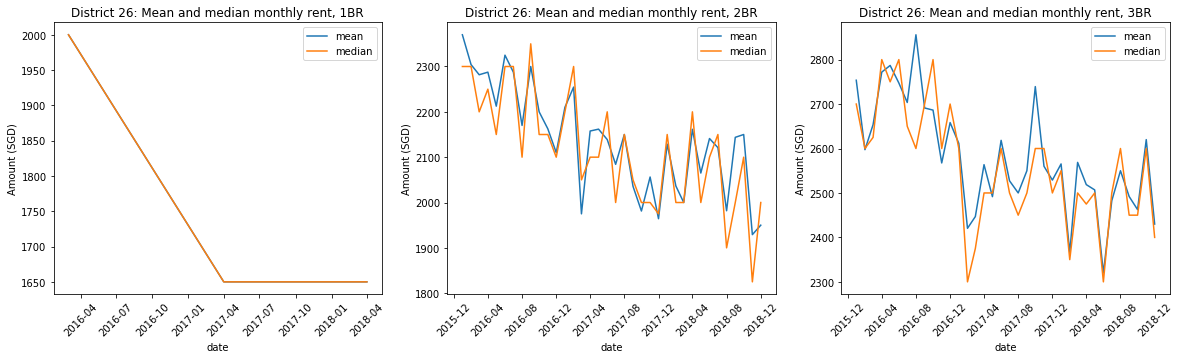

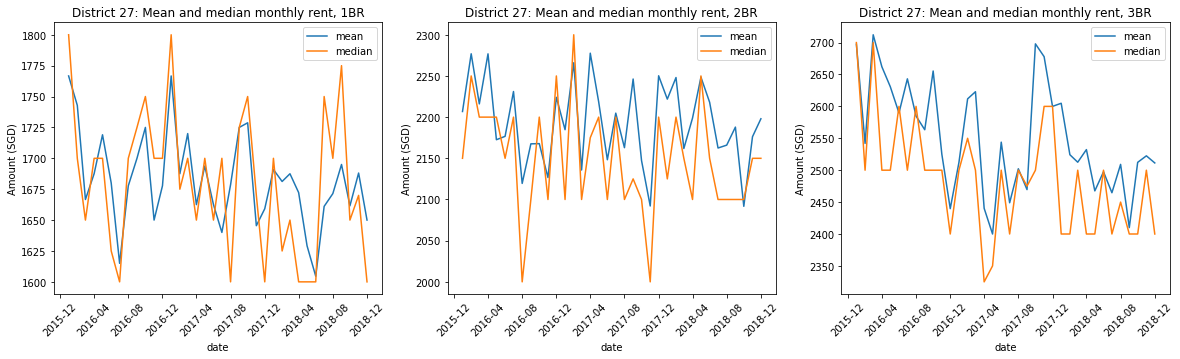

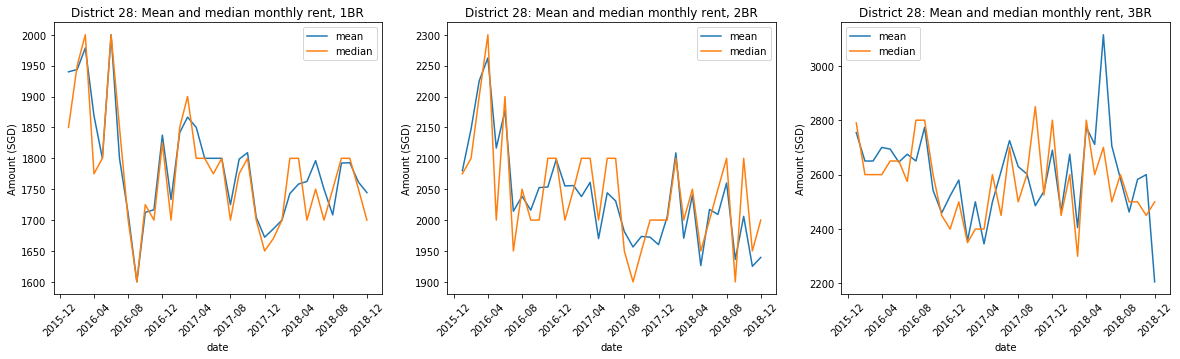

In [1082]:
## sub plot of difference between mean and median for all districts
for i in decision_mean_median.district.unique():
    
    onebr = decision_mean_median.query("num_bedrooms_altered == 1 & district == " + str(i))
    twobr = decision_mean_median.query("num_bedrooms_altered == 2 & district == " + str(i))
    threebr = decision_mean_median.query("num_bedrooms_altered == 3 & district == " + str(i))
    
    plt.figure(figsize=(20,5))
    plt.subplot(1, 3, 1)
    plt.plot(onebr.lease_month,onebr.monthly_rent,label='mean')
    plt.plot(onebr.lease_month,onebr.monthly_rent_copy,label='median')
    plt.xticks(rotation=45)
    plt.title("District " + str(i) + ": Mean and median monthly rent, 1BR")
    plt.xlabel("date")
    plt.ylabel("Amount (SGD)")
    plt.legend(loc='best')
    
    plt.subplot(1, 3, 2)
    plt.plot(twobr.lease_month,twobr.monthly_rent,label='mean')
    plt.plot(twobr.lease_month,twobr.monthly_rent_copy,label='median')
    plt.xticks(rotation=45)
    plt.title("District " + str(i) + ": Mean and median monthly rent, 2BR")
    plt.xlabel("date")
    plt.ylabel("Amount (SGD)")
    plt.legend(loc='best')
    
    plt.subplot(1, 3, 3)
    plt.plot(threebr.lease_month,threebr.monthly_rent,label='mean')
    plt.plot(threebr.lease_month,threebr.monthly_rent_copy,label='median')
    plt.xticks(rotation=45)
    plt.title("District " + str(i) + ": Mean and median monthly rent, 3BR")
    plt.xlabel("date")
    plt.ylabel("Amount (SGD)")
    plt.legend(loc='best')
    

#### The difference between mean and median isnt that much, will be going with mean

In [1061]:
average_model_data = (
    model_data
    .groupby(['lease_month','district','num_bedrooms_altered','time','time_time','time_time_time','m1','m2','m3','m4','m5','m6','m7','m8','m9','m10','m11','m12'])
    .agg({"monthly_rent":"mean","sq_ft_altered":"count"})
    .reset_index()
    .rename(columns={"sq_ft_altered":"num_data_points"})
)

In [1062]:
average_model_data.tail()

,lease_month,district,num_bedrooms_altered,time,time_time,time_time_time,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,monthly_rent,num_data_points
4921,2018-12-01,27,4,36,1296,46656,0,0,0,0,0,0,0,0,0,0,0,1,2975.000000,6
4922,2018-12-01,28,1,36,1296,46656,0,0,0,0,0,0,0,0,0,0,0,1,1744.444444,9
4923,2018-12-01,28,2,36,1296,46656,0,0,0,0,0,0,0,0,0,0,0,1,1939.562500,32
4924,2018-12-01,28,3,36,1296,46656,0,0,0,0,0,0,0,0,0,0,0,1,2206.000000,10
4925,2018-12-01,28,4,36,1296,46656,0,0,0,0,0,0,0,0,0,0,0,1,2733.333333,3


## Forecast rental amount of each month for each district

### Forecast each month, the rental lease for each district
- functionalize for each bedroom type
- districts that have insufficient data will be ignored

In [796]:
def get_each_district_cheapest_month(df, num_BR):
    unique_num_district = df.district.unique()
    summary_model_district_df = None
    aggregate_prediction_df = None
    for i in unique_num_district:
        X = df.query("district == " + str(i) + " & num_bedrooms_altered == " + str(num_BR))[['time','time_time','time_time_time','m1','m2','m3','m4','m5','m6','m7','m8','m9','m10','m11','m12']]
        X = sm.add_constant(X)
        y = df.query("district == " + str(i) + " & num_bedrooms_altered == " + str(num_BR))[['monthly_rent']]
        model_rent = sm.OLS(y,X).fit()
        
        testing = pd.DataFrame(model_rent.pvalues).rename(columns={0:"district_"+str(i)+"_pvalues"}).T
        testing_ = pd.DataFrame(model_rent.params).rename(columns={0:"district_"+str(i)+"_params"}).T
        testing_2 = (
            testing
            .append(testing_)
            .pipe(lambda x:x.assign(r_adj = model_rent.rsquared_adj))
            .pipe(lambda x:x.assign(r_square = model_rent.rsquared))
        )
        if summary_model_district_df is None:
            summary_model_district_df = testing_2
        else:
            summary_model_district_df = summary_model_district_df.append(testing_2)
        try:
            
            prediction_df = (
                pd.DataFrame(model_rent.predict(X))
                .reset_index()
                .merge(y.reset_index(),how='inner',on=['index'])
                .rename(columns={0:"prediction"})
                .merge(average_model_data.reset_index()[['lease_month','index','time']],how='inner',on='index')
                .pipe(lambda x:x.assign(trend = model_rent.params.const +model_rent.params.time * x.time +model_rent.params.time_time * x.time*x.time + model_rent.params.time_time_time *x.time*x.time*x.time))
                .pipe(lambda x:x.assign(seasonal = x.prediction - model_rent.params.time * x.time - model_rent.params.time_time*x.time*x.time - model_rent.params.time_time_time*x.time*x.time*x.time))
                .pipe(lambda x:x.assign(month = pd.to_datetime(x.lease_month).dt.month))    
                .pipe(lambda x:x.assign(district = i))
            )
            
            
            if aggregate_prediction_df is None:
                aggregate_prediction_df = prediction_df
            elif len(prediction_df) < 35:
                pass
            else:
                aggregate_prediction_df = aggregate_prediction_df.append(prediction_df)
        except:
            pass
        
        # check if seasonality exists
        
    
    return summary_model_district_df.dropna(), aggregate_prediction_df

In [797]:
one_bedroom_figures = get_each_district_cheapest_month(average_model_data,1)
two_bedroom_figures = get_each_district_cheapest_month(average_model_data,2)
three_bedroom_figures = get_each_district_cheapest_month(average_model_data,3)

### Based on the forecast, find out which is the lowest (and highest) month. And the savings from each district
- get top 5 saving districts

In [668]:
def get_savings_for_each_district(df):
    unique_districts = df.district.unique()
    aggregate_savings_df = None
    for i in unique_districts:
        current_district_df = (
            df.query("district == " + str(i))
            .groupby(['month'])
            .agg({"seasonal":"mean"})
            .reset_index()
        )
        
        highest_month = current_district_df.seasonal.idxmax() + 1
        highest_month_rental_df = (
            current_district_df
            .query("month == " + str(highest_month))
            .pipe(lambda x:x.assign(district = i))
            .rename(columns={"month":"highest_month","seasonal":"highest_month_rent"})
        )
        lowest_month = (current_district_df.seasonal.idxmin()) + 1
        lowest_month_rental_df = (
            current_district_df
            .query("month == " + str(lowest_month))
            .pipe(lambda x:x.assign(district = i))
            .rename(columns={"month":"lowest_month","seasonal":"lowest_month_rent"})
        )
        savings_district_df = (
            highest_month_rental_df
            .merge(lowest_month_rental_df,how='left',on=['district'])
            .pipe(lambda x:x.assign(savings_per_year = round(12 * (x.highest_month_rent - x.lowest_month_rent),2)))
            [['district','savings_per_year','highest_month','highest_month_rent','lowest_month','lowest_month_rent']]
        )
        
        if aggregate_savings_df is None:
            aggregate_savings_df = savings_district_df
        else:
            aggregate_savings_df = aggregate_savings_df.append(savings_district_df)
    return aggregate_savings_df
        

### To change to 2BR or 3BR change the second line of code to:
- `get_savings_for_each_district(two_bedroom_figures[1])`
- `get_savings_for_each_district(three_bedroom_figures[1])`

In [1097]:
savings_for_each_district_df = (
    get_savings_for_each_district(one_bedroom_figures[1])
    .sort_values(['savings_per_year'],ascending=False)
)

### Show which areas is in each district

In [1098]:
district_areas = pd.read_csv('../data/district_area.csv')
savings_for_each_district_with_location = (
    savings_for_each_district_df
    .merge(district_areas,how='left',on=['district'])
)

savings_for_each_district_with_location.head(2)

,district,savings_per_year,highest_month,highest_month_rent,lowest_month,lowest_month_rent,areas,location
0,7,7854.27,2,3379.240170,11,2724.717388,Beach Road,"Beach Road, Bencoolen Road, Bugis, Rochor"
1,1,4911.53,4,3383.292584,6,2973.998541,Marina Area,"Boat Quay, Chinatown, Havelock Road, Marina Sq..."


### Predict the next 24 months of rental for each district

### Ensemble of both methods, holt winter and fb-prophet

In [1099]:
def predict_next_24_months_rental(df):
    unique_districts_available = df.district.unique()
    aggregate_predict_next_24months = None
    for i in unique_districts_available:
        current_district_df = (
            df
            .query("district == " + str(i))
            [['lease_month','monthly_rent']]
            .rename(columns={"lease_month":"ds",'monthly_rent':'y'})
        )
        
        # prophet forecast
        m = Prophet()
        m.fit(current_district_df)
        future = m.make_future_dataframe(periods=24,freq='m')
        forecast = (
            m.predict(future)
            [['ds','yhat']]
            .pipe(lambda x:x.assign(ds = np.where(x.ds > '2018-12-01',x.ds+timedelta(days=1),x.ds)))
        )
        
        #holt winters forecast
        fit1 = ExponentialSmoothing(np.asarray(current_district_df['y']) ,seasonal_periods=12,trend='add', seasonal='add',).fit()
        hw_forecast = (
            pd.DataFrame(fit1.forecast(24))
            .pipe(lambda x:x.assign(ds = forecast.query("ds > '2018-12-01'").ds.values))
        )
        hw_fit = (
            pd.DataFrame(fit1.fittedvalues)
            .pipe(lambda x:x.assign(ds = forecast.query("ds <= '2018-12-01'").ds.values))
        )
        
        hw_forecast_fit = (
            hw_fit
            .append(hw_forecast)
            .rename(columns={0:"holtwinter"})
        )
        
        prophet_hw_combine = (
            forecast
            .merge(hw_forecast_fit,how='left',on=['ds'])
            .merge(current_district_df,how='left',on=['ds'])
            .fillna(0)
            .rename(columns={"yhat":"fbprophet","y":"actual_monthly_rent"})
        )
        
        X = prophet_hw_combine.query("ds <= '2018-12-01'")[['fbprophet','holtwinter']]
        y = prophet_hw_combine.query("ds <= '2018-12-01'")[['actual_monthly_rent']]
        weight_model = sm.OLS(y,X).fit()
        
        prophet_hw_combine = (
            prophet_hw_combine
            .pipe(lambda x:x.assign(ensemble_model_output = weight_model.params.fbprophet * x.fbprophet + weight_model.params.holtwinter * x.holtwinter))
            .pipe(lambda x:x.assign(district = i.astype(int)))
        )
        
        if aggregate_predict_next_24months is None:
            aggregate_predict_next_24months = prophet_hw_combine
        else:
            aggregate_predict_next_24months = aggregate_predict_next_24months.append(prophet_hw_combine)
        
        
#         fig2 = m.plot_components(forecast)
    return aggregate_predict_next_24months
        

In [1100]:
predict_future_values = predict_next_24_months_rental(one_bedroom_figures[1])

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

### combine both lowest month and duration
- assuming you rented in the lowest month, looking ahead in the next year, how much will you save?

In [1101]:
intermediate_df = (
    predict_future_values
    .pipe(lambda x:x.assign(previous_year = x.ds + timedelta(days=-365)))
    .pipe(lambda x:x.assign(previous_year = np.where(x.previous_year.dt.day==2,x.previous_year+timedelta(days=-1),x.previous_year)))
    .merge(savings_for_each_district_with_location[['district','lowest_month']],how='left',on=['district'])
)

savings_for_longer_lease = (
    intermediate_df
    .merge(intermediate_df[['ds','ensemble_model_output','district']],how='inner',left_on=['previous_year','district'],right_on=['ds','district'])
    .pipe(lambda x:x.assign(lowest_month_date = pd.to_datetime(str("2018-")+(x.lowest_month.astype(str))+"-01")))
    .query("ds_y == lowest_month_date")
    .drop(['ds_y'],1)
    .rename(columns={"ds_x":"ds","ensemble_model_output_x":"ensemble_model_output","ensemble_model_output_y":"previous_year_rental"})
    .pipe(lambda x:x.assign(savings_24months_lease = 12 * (x.holtwinter-x.previous_year_rental)))
    .pipe(lambda x:x.assign(should_extend_lease = np.where(x.savings_24months_lease>0,1,0)))
)

total_savings_for_longer_lease_lowest_months = (
    savings_for_longer_lease
    .merge(savings_for_each_district_with_location[['savings_per_year','district','location','highest_month']],how='left',on=['district'])
    .pipe(lambda x:x.assign(total_savings_per_year = x.should_extend_lease * x.savings_24months_lease + x.savings_per_year))
    .drop(['actual_monthly_rent'],1)
    .sort_values(['total_savings_per_year'],ascending=False)
)

In [1124]:
total_savings_for_longer_lease_lowest_months[['district','location','lowest_month','highest_month','savings_per_year','savings_24months_lease','should_extend_lease','total_savings_per_year']].head(5)

,district,location,lowest_month,highest_month,savings_per_year,savings_24months_lease,should_extend_lease,total_savings_per_year
5,7,"Beach Road, Bencoolen Road, Bugis, Rochor",11,2,7854.27,-1271.525302,0,7854.270000
0,1,"Boat Quay, Chinatown, Havelock Road, Marina Sq...",6,4,4911.53,-161.031362,0,4911.530000
19,21,"Clementi, Upper Bukit Timah, Hume Avenue",1,8,2659.52,2070.576103,1,4730.096103
1,2,"Anson Road, Chinatown, Neil Road, Raffles Plac...",3,11,4440.15,-1616.438359,0,4440.150000
2,3,"Alexandra Road, Tiong Bahru, Queenstown",1,3,1956.64,1703.878584,1,3660.518584


In [1123]:
districts_to_focus = total_savings_for_longer_lease_lowest_months.head(5).district.unique()

#### Districts to focus are 7, 1, 21 ,2, 3, 4, 9, 22, 11, 20

### Plot out top 10 districts
- plot out prediction, trend
- plot out seasonal on the side

In [1136]:
(
    total_savings_for_longer_lease_lowest_months
    .head()
    [['district','location','lowest_month','highest_month','savings_24months_lease','should_extend_lease','savings_per_year','total_savings_per_year']]
    .rename(columns={"savings_per_year":"savings_per_year_from_renting_lowest_month","should_extend_lease":"should_sign_24_months_lease"})
)

,district,location,lowest_month,highest_month,savings_24months_lease,should_sign_24_months_lease,savings_per_year_from_renting_lowest_month,total_savings_per_year
5,7,"Beach Road, Bencoolen Road, Bugis, Rochor",11,2,-1271.525302,0,7854.27,7854.270000
0,1,"Boat Quay, Chinatown, Havelock Road, Marina Sq...",6,4,-161.031362,0,4911.53,4911.530000
19,21,"Clementi, Upper Bukit Timah, Hume Avenue",1,8,2070.576103,1,2659.52,4730.096103
1,2,"Anson Road, Chinatown, Neil Road, Raffles Plac...",3,11,-1616.438359,0,4440.15,4440.150000
2,3,"Alexandra Road, Tiong Bahru, Queenstown",1,3,1703.878584,1,1956.64,3660.518584


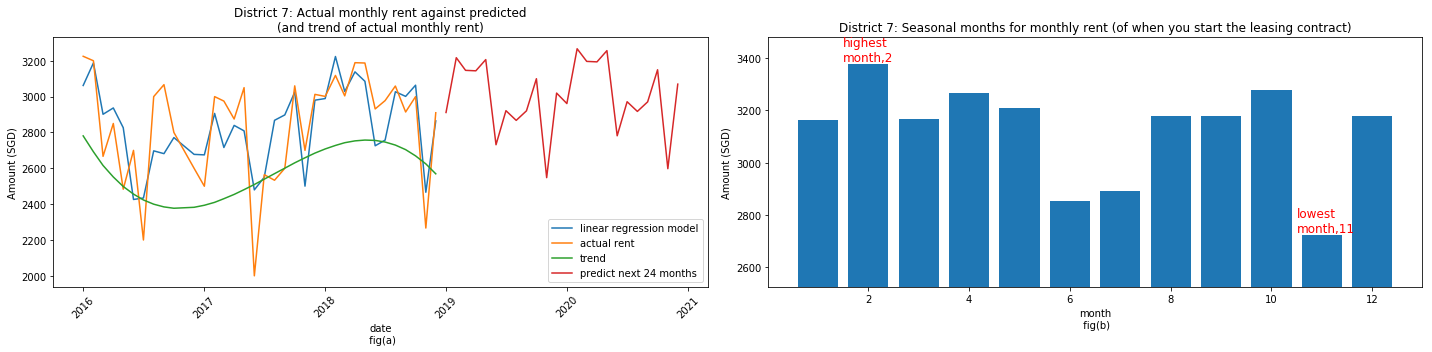

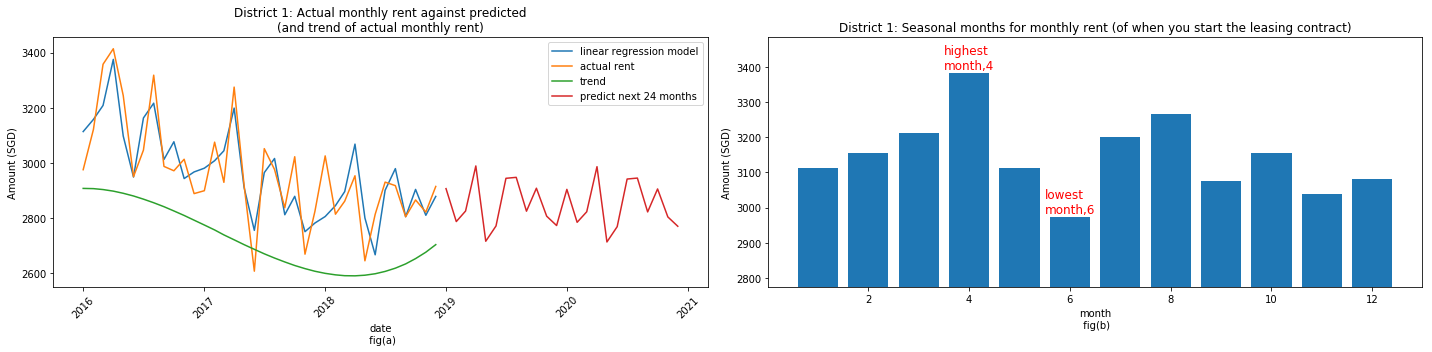

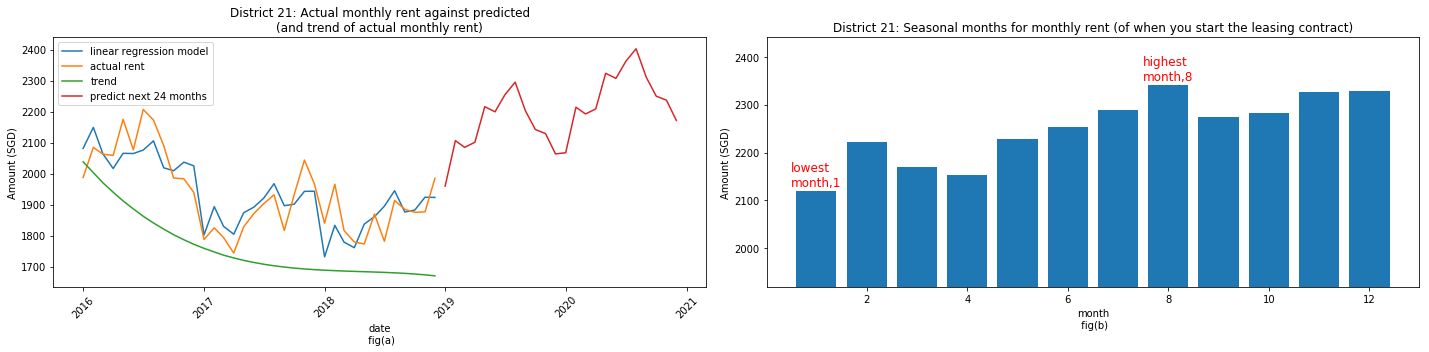

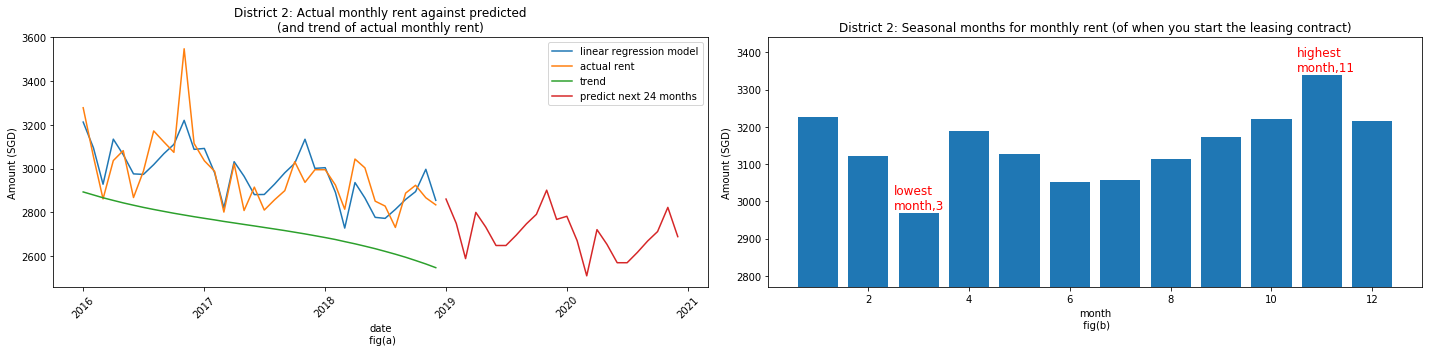

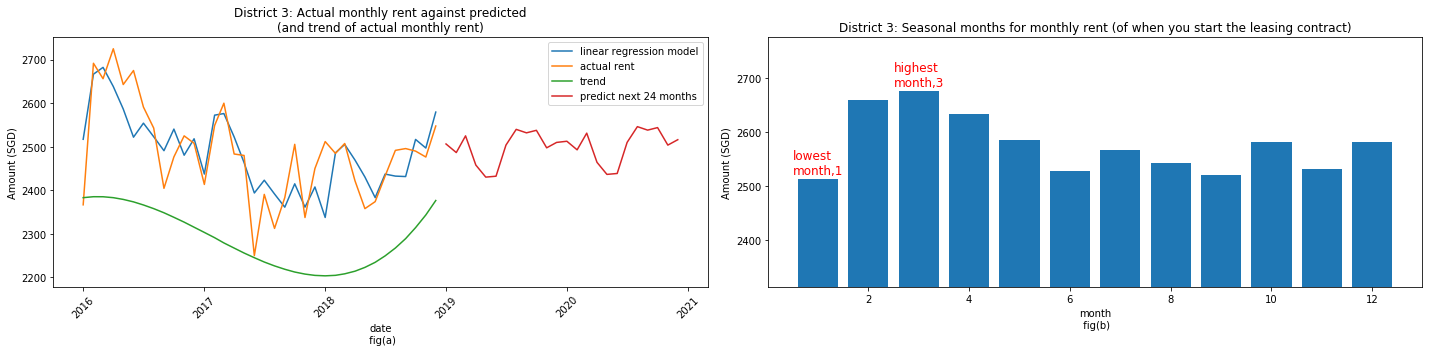

In [1138]:
for i in districts_to_focus:
    focus_plot_df = (
        one_bedroom_figures[1]
        .query("district == " + str(i))
        [['lease_month','month','district','prediction','monthly_rent','trend','seasonal']]
    )
    
    focus_predict_plot_df = (
        predict_future_values
        .query("district == " + str(i))
        [['ds','actual_monthly_rent','ensemble_model_output','holtwinter']]
    )
    
    lowest_month = savings_for_each_district_with_location.query("district == " + str(i)).lowest_month.values[0]
    lowest_month_rent = savings_for_each_district_with_location.query("district == " + str(i)).lowest_month_rent.values[0]
    highest_month = savings_for_each_district_with_location.query("district == " + str(i)).highest_month.values[0]
    highest_month_rent = savings_for_each_district_with_location.query("district == " + str(i)).highest_month_rent.values[0]
    
    plt.figure(figsize=(20,5))
    plt.subplot(1, 2, 1)
    plt.plot(focus_plot_df.lease_month,focus_plot_df.prediction,label='linear regression model')
    plt.plot(focus_plot_df.lease_month,focus_plot_df.monthly_rent,label='actual rent')
    plt.plot(focus_plot_df.lease_month,focus_plot_df.trend,label='trend')
    plt.plot(focus_predict_plot_df.query("ds > '2018-12-01'").ds,focus_predict_plot_df.query("ds > '2018-12-01'").holtwinter,label='predict next 24 months')
    plt.xticks(rotation=45)
    plt.title("District " + str(i) + ": Actual monthly rent against predicted\n(and trend of actual monthly rent)")
    plt.xlabel("date\n fig(a)")
    plt.ylabel("Amount (SGD)")
    plt.legend(loc='best')
    
    plt.subplot(1, 2, 2)
    plt.bar(focus_plot_df.month,focus_plot_df.seasonal,label='seasonal')
    plt.title("District " + str(i) + ": Seasonal months for monthly rent (of when you start the leasing contract)")
    plt.text(lowest_month-0.5,lowest_month_rent+10,"lowest\nmonth,"+str(lowest_month),color='red',fontsize='12')
    plt.text(highest_month-0.5,highest_month_rent+10,"highest\nmonth,"+str(highest_month),color='red',fontsize='12')
    plt.xlabel("month\n fig(b)")
    plt.ylim(bottom=lowest_month_rent-200)
    plt.ylim(top=highest_month_rent+100)
    plt.ylabel("Amount (SGD)")
    
    plt.tight_layout()

### Conclusion
- Assumptions:
    1. the prediction of the rental amount in the next 24 months is assuming all things stay constant, and there is no new cooling property measure introduced
    1. we did an average over district, and did not look into specific area (example: bukit panjang or tiong bahru). if looked into specific areas, there might be differences between areas.
- Constraints:
    1. the prediction accuracy can be further improved if a better model is applied, however to reduce complexity, 2 simple models were used to

### Next steps
- while this is done for rental lease, an similar exercise will be replicated for property sale